In [28]:
import gen
import eval
from decaGEN import grammar
import pandas as pd

model = 'WSWSWSWSWS'
o1980 = grammar(model, gen.oliva1980, eval.oliva1980, False)
o1992 = grammar(model, gen.oliva1992b, eval.oliva1992b, False)
j2019 = grammar('', gen.jimenez2019, eval.jimenez2019, False)

## Anàlisi de les gramàtiques generades

In [29]:
# identifica els patrons comuns entre les gramàtiques (df)
def common_patterns(df1, df2):
    patterns1 = set(df1['Exemple'])
    patterns2 = set(df2['Exemple'])
    common = patterns1.intersection(patterns2)
    return common
common_o1980_o1992 = common_patterns(o1980, o1992)
common_o1980_j2019 = common_patterns(o1980, j2019)
common_o1992_j2019 = common_patterns(o1992, j2019)

print('Common patterns between Oliva 1980 and Oliva 1992:', len(common_o1980_o1992))
print('Common patterns between Oliva 1980 and Jimenez 2019:', len(common_o1980_j2019))
print('Common patterns between Oliva 1992 and Jimenez 2019:', len(common_o1992_j2019))

Common patterns between Oliva 1980 and Oliva 1992: 21
Common patterns between Oliva 1980 and Jimenez 2019: 40
Common patterns between Oliva 1992 and Jimenez 2019: 24


In [30]:
# Genera un únic dataframe amb tots els patrons. Elimina duplicats, però afegeix una columna que indica en quines gramàtiques apareix cada patró. Desa també el valor de complexitat de cada gramàtica per a cada patró: 'complexitat_o1980', 'complexitat_o1992', 'complexitat_j2019'
def merge_grammars(df1, df2, df3):
    all_patterns = pd.concat([df1, df2, df3]).drop_duplicates(subset=['Exemple']).reset_index(drop=True)
    all_patterns['In_Oliva1980'] = all_patterns['Exemple'].isin(df1['Exemple'])
    all_patterns['In_Oliva1992'] = all_patterns['Exemple'].isin(df2['Exemple'])
    all_patterns['In_Jimenez2019'] = all_patterns['Exemple'].isin(df3['Exemple'])

    def get_complexity(row, df, col_name):
        if row['Exemple'] in df['Exemple'].values:
            return df.loc[df['Exemple'] == row['Exemple'], 'Complexitat'].values[0]
        return None

    all_patterns['Complexitat_Oliva1980'] = all_patterns.apply(lambda row: get_complexity(row, df1, 'Complexitat'), axis=1)
    all_patterns['Complexitat_Oliva1992'] = all_patterns.apply(lambda row: get_complexity(row, df2, 'Complexitat'), axis=1)
    all_patterns['Complexitat_Jimenez2019'] = all_patterns.apply(lambda row: get_complexity(row, df3, 'Complexitat'), axis=1)

    return all_patterns
merged_grammars = merge_grammars(o1980, o1992, j2019)
merged_grammars.to_excel('merged_grammars.xlsx', index=False)

In [31]:
# Estadístiques bàsiques
def basic_statistics(df, name):
    total_patterns = len(df)
    avg_complexity = df['Complexitat'].mean()
    print(f'Statistics for {name}:')
    print(f'Total patterns: {total_patterns}')
    print(f'Average complexity: {avg_complexity:.2f}\n')
basic_statistics(o1980, 'Oliva 1980')
basic_statistics(o1992, 'Oliva 1992')
basic_statistics(j2019, 'Jimenez 2019')

Statistics for Oliva 1980:
Total patterns: 40
Average complexity: 2.20

Statistics for Oliva 1992:
Total patterns: 72
Average complexity: 4.38

Statistics for Jimenez 2019:
Total patterns: 512
Average complexity: 3.17



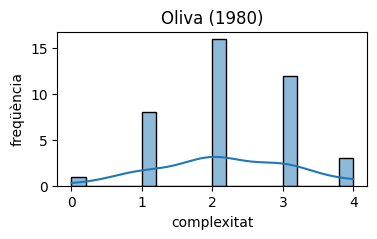

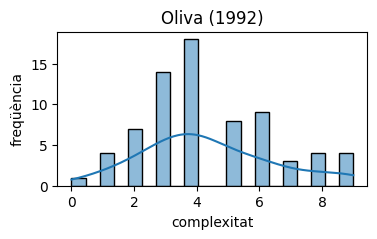

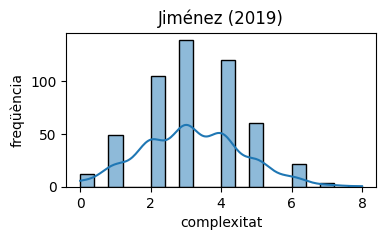

In [37]:
# plots de distribució de complexitat
import matplotlib.pyplot as plt
import seaborn as sns
def plot_complexity_distribution(df, name):
    plt.figure(figsize=(4, 2))
    sns.histplot(df['Complexitat'], bins=20, kde=True)
    plt.title(f'{name}')
    plt.xlabel('complexitat')
    plt.ylabel('freqüència')
    plt.show()
plot_complexity_distribution(o1980, 'Oliva (1980)')
plot_complexity_distribution(o1992, 'Oliva (1992)')
plot_complexity_distribution(j2019, 'Jiménez (2019)')